# **ETPoF** Homework 2
Annemarie Linnenbank & Tommie Verouden

*8 March 2024*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.spatial as spatial
from sklearn.cluster import DBSCAN

## Part a: Optical Calibration (13 points)

In this part, we work towards a fully-fledged optical calibration function. For clarity, we will go through all the steps contained within the function in the exercises, so we can show some intermediate results too. The full function is added after part 2a3 - it functions identically to the results.

### 2a1) **Image resolution**

We start by importing the image using the OpenCV library.

In [2]:
# Import the first image in grayscale
img_path = "Images/Calibration_a/Clean.png"
img = cv.imread(img_path, 0)

#### Circle detection

We apply a Hough circle transform to detect circles in the image, after which we remove circles that overlap with the image border. The parameters of the detector have been determined empirically, and we used the `HOUGH_GRADIENT_ALT` algorithm, since it is supposed to be more accurate (see https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad). The distance and radii parameters are estimated by counting the circles per pixel by eye.

In [3]:
def detect_circles(img_edges, min_dist, min_radius, max_radius,
                   dP = 1.5, canny_thresh = 100, perfectness = 0.8, boundary_px = 0):
    '''Detect circles in an edge-detected image using the Hough transform

    PARAMETERS
        img_edges (np.array): The edge-detected image
        min_dist (int): Minimum distance between the centers of the detected circles
        min_radius (int): Minimum radius of the detected circles
        max_radius (int): Maximum radius of the detected circles
        dP (int): Inverse ratio of the accumulator resolution to the image resolution
        canny_thresh (int): The upper threshold for the Canny edge detector
        perfectness (int): How circular the circles should be in the ALT algorithm

    RETURNS
        circles (np.array): The detected circles
    '''

    # === DETECTION ===
    # Apply Hough transform on the edge-detected image
    circles = cv.HoughCircles(img_edges, cv.HOUGH_GRADIENT_ALT,
                              dP, min_dist, param1 = canny_thresh, param2 = perfectness,
                           minRadius = min_radius, maxRadius = max_radius)
    
    # Warn when no circles are detected
    if circles is None:
        print('No circles detected!')
        return None, None
    
    # Convert the circles to a list, split array
    circles = circles[0, :, :]
    centers = circles[:,0:2]
    radii = circles[:,2]


    # === MASKING ===
    # Get the indices of circles that overlap with the image boundary
    overlapping = (centers[:,0] - radii - boundary_px < 0) | \
                    (centers[:,0] + radii + boundary_px > img_edges.shape[0]) | \
                    (centers[:,1] - radii - boundary_px < 0) | \
                    (centers[:,1] + radii + boundary_px > img_edges.shape[1])
    
    # Remove the overlapping circles from the lists
    centers = centers[~overlapping]
    radii = radii[~overlapping]

    # Return the center coordinates and circle radii
    return centers, radii

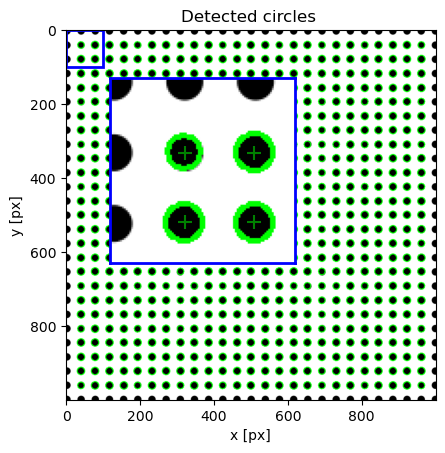

In [4]:
# Detect circles in the edge-detected image
centers_px, radii_px = detect_circles(img, min_dist=10, min_radius=5, max_radius=20)

# Plot the circles on the original image
img_rgb = cv.imread(img_path)
fig, ax = plt.subplots()
for center, radius in zip(centers_px, radii_px):
    cv.circle(img_rgb, (center[0].astype(int), center[1].astype(int)), radius.astype(int), (0, 255, 0), 2)
ax.imshow(img_rgb)

ax.set_title('Detected circles ')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

# Make an inset of the top left corner of the image
inset = [0, 100]
ax.add_patch(plt.Rectangle((inset[0], inset[0]), inset[1]-inset[0], inset[1]-inset[0],
            fill=False, color='b', linewidth=2))
axins = ax.inset_axes([0.12, 0.37, 0.5, 0.5], xlim=inset, ylim=np.flip(inset), xticks=[], yticks=[])
axins.imshow(img_rgb, cmap='gray', origin="upper")
axins.scatter(centers_px[:, 0], centers_px[:, 1], c="g", s=100, marker="+")
axins.spines[:].set_color('blue')
axins.spines[:].set_linewidth(2)
plt.show()

Note that the circles can only be drawn on the image with a full pixel accuracy on both the radius and the center. There is, however, some inaccuracy present in the Hough transform, since it is limited to 0.5 px when determining the center coordinates. A more accurate approach might be the FindCirclesGrid() algorithm in the OpenCV library, which we will later compare the result to.

First, we calculate the distances between all points.

In [5]:
def calc_distance_between_all_points(x, y):
    xy = np.column_stack([x, y])

    # Calculate the distance between all points
    distances_px = spatial.distance.cdist(xy, xy, 'euclidean')

    return distances_px

# Calculate the distance between all points
dist_px = calc_distance_between_all_points(centers_px[:, 0], centers_px[:, 1])

From these distances and the given calibration distance, we would like to calculate the resolution. However, for that, we need to know how many dots are actually spanned by the distances in the `dist_px` matrix. One problem: the output of the Hough transform is in an arbitrary order. Therefore, we first sort the coordinates by x and y values.

In [6]:
# Sort the coordinates by x and y
centers_px_sorted = centers_px[np.lexsort((centers_px[:, 0], centers_px[:, 1]))]

This straightforward sorting operation only works in this case because, as it turns out, the coordinates could all be determined with 0.5 px precision, meaning that the x-coordinates of the dots in each column (and y-coordinates in each row) are exactly equal. Later, we will show a more robust method.

#### Resolution calculation

From the sorting indices of each circle, we can calculate the distance in "dot units". 

In [63]:
# Calculate the dot-space distances
dist_id = calc_distance_between_all_points(centers_id_sorted[:, 0], centers_id_sorted[:, 1])

# resolution given by each distance


# Calculate the average distance between all points
# dist_px_avg, dist_px_std = weighted_avg_and_std()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [33]:
def weighted_avg_and_std(values, weights, mask_diagonal=True):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted average and standard deviation.
        weights (array-like): The weights corresponding to each value.

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal:
        mask = np.eye(values.shape[0], dtype=bool).__invert__()

    # Calculate the weighted average
    average = np.average(values, weights=weights)

    # Calculate the weighted variance
    variance = np.average((values-average)**2, weights=weights)

    # Output the average and standard deviation
    return (average, np.sqrt(variance))

#### Accuracy comparison

### 2a2) **Noise, rotation & lens vignetting**

In our experience, the upcoming circle detection algorithm is most robust when working with only circle edges - compared to filled circles. Therefore, we apply some light pre-processing (to be elaborated upon in part 2a2) in the form of Canny edge detection.

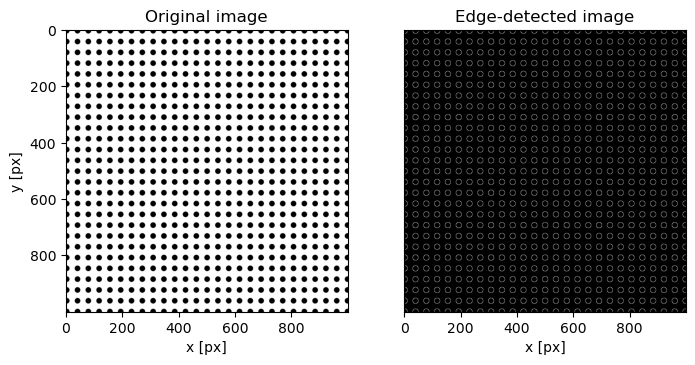

In [ ]:
def get_circle_edges(img, threshold1=70, threshold2=255):
    '''Canny edge detection with predefined parameters
    
    PARAMETERS
        img (np.array): The input image
        threshold1 (int): First empirical threshold
        threshold2 (int): Second empirical threshold
    
    RETURNS
        edges (np.array): The edge-detected image (binary; edges are white)
    '''

    # Apply Canny edge detection
    img_edges = cv.Canny(img, threshold1, threshold2)

    return img_edges


# Get the edges of the image using the default, empirically determined, parameters
img_edges = get_circle_edges(img)

# Show the original image and the edges
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')

ax[1].imshow(img_edges, cmap='gray')
ax[1].set_title('Edge-detected image')
ax[1].set_yticks([])
ax[1].set_xlabel('x [px]')
plt.show()


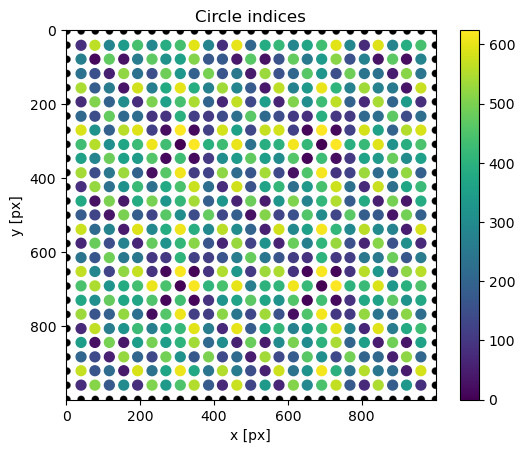

In [ ]:
# Plot the circle centers with a color corresponding to the index
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.scatter(centers_px[:, 0], centers_px[:, 1], c=range(len(centers_px)), s=50)
ax.set_title('Circle indices')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

# Add a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
plt.show()


#### Circle sorting
We would like to sort the circles by x and y coordinates. However, there might, of course, be slight inaccuracies in both values, making this not so trivial. At this point, rounding the centers 

The following solution might be a bit overkill, but it is quick and reliable: we use a tiny bit of machine learning to cluster the points in two dimensions. The algorithm we used is called "Density-Based Spatial Clustering of Applications with Noise" or DBSCAN, which groups neighbouring points together without prior knowledge on the number of clusters (see also https://en.wikipedia.org/wiki/DBSCAN).

In [ ]:
# Sort the circle coordinates by x
centers_px_sorted = centers_px.copy()
centers_px_sorted = centers_px_sorted[centers_px_sorted[:, 0].argsort()]

# Minimum distance between clusters is the average circle diameter
min_dist = 2 * np.mean(radii_px)

# Perform clustering in the y direction, fit model to data
dbscan_x = DBSCAN(eps=min_dist, min_samples=2)
dbscan_x.fit(centers_px_sorted[:, 0].reshape(-1, 1))

# Make an array of the cluster numbers in the x direction for each circle
centers_id = dbscan_x.labels_

# Sort the data points and the clusters array by y coordinate
sort_y = centers_px_sorted[:, 1].argsort()
centers_px_sorted = centers_px_sorted[sort_y]
centers_id = centers_id[sort_y]

# Perform clustering in the x direction, fit model to data
dbscan_y = DBSCAN(eps=min_dist, min_samples=2)
dbscan_y.fit(centers_px_sorted[:, 1].reshape(-1, 1))

# Add a dimension to the clusters array
centers_id = np.vstack((centers_id, dbscan_y.labels_)).T

indices = np.lexsort((centers_id[:, 0], centers_id[:, 1]))
centers_id = centers_id[indices]
centers = centers_px_sorted[indices]


# Count the number of clusters
grid_size = [len(np.unique(dbscan_x.labels_)), len(np.unique(dbscan_y.labels_))]

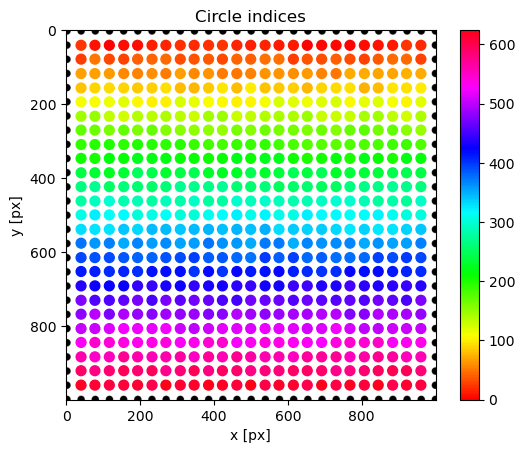

In [ ]:
# Plot the circle centers with a color corresponding to the index
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.scatter(centers_px_sorted[:, 0], centers_px_sorted[:, 1], c=range(len(centers_px_sorted)), cmap="hsv", s=50)
ax.set_title('Circle indices')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

# Add a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
plt.show()

### 2a3) **Radially-varying resolution**

### **Full optical calibration function**